# Nike and Adidas Sneaker Image Classification

Two of the largest sportswear companies in the world, Nike and Adidas, make some of the most popular shoes in the world. Ranging from lifestyle shoes to performance sports sneakers, the notorious Nike *Swoosh* and the Adidas *three stripes* are recognizable all over the world. But can we create a model to descerne between the two? What would a hybrid Nike and Adidas sneaker look like? Let's see what we can do with Connvolutional Neural Networks and Generative Adverserial Networks.

We will import more images from a [second Kaggle dataset](https://www.kaggle.com/datasets/die9origephit/nike-adidas-and-converse-imagedhttps://www.kaggle.com/datasets/die9origephit/nike-adidas-and-converse-imaged) to supplement the images.

We will begin by importing the necessary python packages.

In [1]:
# Import modules
import pandas as pd
import numpy as np
import seaborn as sns
import cv2
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import os
# import shutil
import random
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, RocCurveDisplay, roc_auc_score
from tensorflow.keras.applications import ResNet50V2 #EfficientNetB1
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Adjust seaborn plot settings
sns.set(rc={"figure.figsize":(10, 7)})
sns.set_style("whitegrid")

In [2]:
# Set filepaths
path_to_labels = '../input/nike-adidas-shoes-for-image-classification-dataset/labelnames.csv'
path_to_training_imgs = '../input/nike-adidas-shoes-for-image-classification-dataset/train'
path_to_testing_imgs = '../input/nike-adidas-shoes-for-image-classification-dataset/test'
path_to_validation_imgs = '../input/nike-adidas-shoes-for-image-classification-dataset/validation'
# secondary dataset images
path_to_training_imgs_2 = '../input/nike-adidas-and-converse-imaged/train'
path_to_testing_imgs_2 = '../input/nike-adidas-and-converse-imaged/test/'


#########################################################
### IN KAGGLE WE CANNOT MOVE IMAGES TO NEW DIRECTORY. ###
### THEREFORE WE WILL USE A DATAFRAME TO INFORM THE   ###
### DIRECTORIES TO READ EACH FILE FROM                ###
#########################################################

# # move the secondary images to the primary image folder
# def moveSecondaryFiles(dest_path, source_path, co):
#     for img in os.listdir(source_path + '/' + co):
#         shutil.copy(source_path + '/' + co + '/' + img, dest_path + '/' + co)

# # nike training
# moveSecondaryFiles(path_to_training_imgs, path_to_training_imgs_2, 'nike')

# # adidas training
# moveSecondaryFiles(path_to_training_imgs, path_to_training_imgs_2, 'adidas')

# # nike testing
# moveSecondaryFiles(path_to_testing_imgs, path_to_testing_imgs_2, 'nike')

# # adidas testing
# moveSecondaryFiles(path_to_testing_imgs, path_to_testing_imgs_2, 'adidas')

### Dataframe for Image Directories

We will use the `flow_from_dataframe` method in tensorflow that will allow us to read in and process the image files from multiple directories.

In [3]:
# Nike
nike_train_img_1 = [
    path_to_training_imgs + '/nike/' + file for file in os.listdir(path_to_training_imgs + '/nike')
]

nike_train_img_2 = [
    path_to_training_imgs_2 + '/nike/' + file for file in os.listdir(path_to_training_imgs_2 + '/nike')
]

nike_test_img_1 = [
    path_to_testing_imgs + '/nike/' + file for file in os.listdir(path_to_testing_imgs + '/nike')
]

nike_test_img_2 = [
    path_to_testing_imgs_2 + '/nike/' + file for file in os.listdir(path_to_testing_imgs_2 + '/nike')
]

nike_train_img_list = (nike_train_img_1 
                       + nike_train_img_2
                       + nike_test_img_1
                       + nike_test_img_2)

# Adidas 
adidas_train_img_1 = [
    path_to_training_imgs + '/adidas/' + file for file in os.listdir(path_to_training_imgs + '/adidas')
]

adidas_train_img_2 = [
    path_to_training_imgs_2 + '/adidas/' + file for file in os.listdir(path_to_training_imgs_2 + '/adidas')
]

adidas_test_img_1 = [
    path_to_testing_imgs + '/adidas/' + file for file in os.listdir(path_to_testing_imgs + '/adidas')
]

adidas_test_img_2 = [
    path_to_testing_imgs_2 + '/adidas/' + file for file in os.listdir(path_to_testing_imgs_2 + '/adidas')
]

adidas_train_img_list = (adidas_train_img_1 
                       + adidas_train_img_2
                       + adidas_test_img_1
                       + adidas_test_img_2)

nike_filepath_df = pd.DataFrame({
    'file_paths' : nike_train_img_list,
    'label' : 'Nike'
})

adidas_filepath_df = pd.DataFrame({
    'file_paths' : adidas_train_img_list,
    'label' : 'Adidas'
})

img_filepaths_df = pd.concat([adidas_filepath_df, nike_filepath_df], ignore_index=True)

In [4]:
img_filepaths_df.describe()

,file_paths,label
count,1070,1070
unique,1070,2
top,../input/nike-adidas-shoes-for-image-classific...,Adidas
freq,1,535


In [5]:
img_filepaths_df['label'].value_counts()

Adidas    535
Nike      535
Name: label, dtype: int64

## Example Images
Looks like our image labels are balanced. Let's inspect some images before preprocessing for modeling.

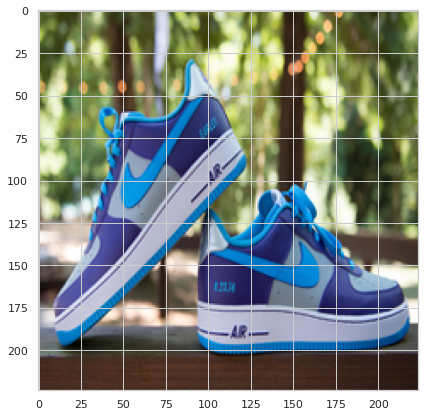

In [6]:
# Read image
ex_img = mpimg.imread(img_filepaths_df.iloc[552, 0]) # first row, filepath column
# mpimg.imread(path_to_training_imgs + '/nike' + '/Image_1.jpg')
plt.imshow(ex_img);

## Determining Image Size

Before we can begin creating our CNN, we must ensure that all the images are preprocessed to have the same size. Most appear to have the shape (224, 224, 3).

In [7]:
def getImageShape(path_to_images):
    """Reads image from filepath and returns image shape"""
    image = cv2.imread(path_to_images)
    shape = image.shape
    return shape

# Get image shapes 
image_shapes_list = []
for img in img_filepaths_df['file_paths']:
    image_shapes_list.append(getImageShape(img))

print("Image shapes:\n", set(image_shapes_list))

Image shapes:
 {(683, 683, 3), (546, 970, 3), (1920, 2560, 3), (676, 1200, 3), (218, 332, 3), (483, 700, 3), (300, 250, 3), (198, 332, 3), (1124, 1686, 3), (725, 966, 3), (497, 651, 3), (300, 285, 3), (825, 1625, 3), (796, 640, 3), (240, 240, 3), (224, 224, 3), (230, 332, 3)}


## Splitting The Dataset

Before we begin building the model, we must split our dataset into training (and validation), and testing sets to properly asses the model.

In [8]:
# Create training subset
training_size = len(img_filepaths_df)*0.7
random.seed(1)
x_index = random.sample(list(img_filepaths_df.index.values), int(training_size))
training_df = img_filepaths_df.iloc[x_index, ]

# Create validation subset 
val_size = training_size*0.3
random.seed(2)
val_index = random.sample(list(training_df.index.values), int(val_size))
val_df = img_filepaths_df.iloc[val_index, ]

# Create testing subset
testing_df = img_filepaths_df.iloc[
    [i for i in img_filepaths_df.index.values if i not in training_df.index.values],
]

assert len(testing_df) + len(training_df) == len(img_filepaths_df)
assert len([i for i in training_df.index if i in testing_df.index]) == 0

## Model Architecture

We can now begin creating the architecture for our CNN.

In [9]:
def makeResNetModel():
    """Transfer learning resnet model"""
    eff_model = ResNet50V2(
        include_top=False, 
        input_shape=(224, 224, 3),
        classes=2
    )

    for layer in eff_model.layers[:-1]:
        layer.trainable = False
    
    x = eff_model.output
    x = Flatten()(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.2)(x)
    x = Dense(64, activation="relu")(x)

    predictions = Dense(1, activation="sigmoid")(x)

    # creating the final model 
    model = Model(eff_model.input, predictions)   
    return model

In [10]:
model = makeResNetModel()

2022-12-02 14:56:14.981945: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 14:56:15.107086: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 14:56:15.108412: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 14:56:15.112033: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

94683136/94668760 [==============================] - 0s 0us/step


In [11]:
optimizer = Adam(learning_rate=1e-3)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [12]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0, 
    rotation_range=30,
    horizontal_flip=True,
    channel_shift_range=True
)

val_datagen = ImageDataGenerator(
    rescale=1.0/255.0, 
    rotation_range=30,
    horizontal_flip=True,
    channel_shift_range=True
)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

batch_size = 150
val_batch_size = 70

train_generator = train_datagen.flow_from_dataframe(training_df, 
                                                    x_col='file_paths',
                                                    y_col='label',
                                                    class_mode='binary',
                                                    batch_size=batch_size,
                                                    target_size=(224, 224),
                                                    shuffle=True,
                                                    seed=10)

validation_generator = val_datagen.flow_from_dataframe(val_df,
                                                       x_col='file_paths',
                                                       y_col='label',
                                                       class_mode='binary',
                                                       batch_size=val_batch_size,
                                                       target_size=(224, 224),
                                                       shuffle=True,
                                                       seed=11)

Found 749 validated image filenames belonging to 2 classes.
Found 224 validated image filenames belonging to 2 classes.


## View Sample Image transformations

Using the `flow_from_directory` method, we will see some sample images after the preprocessing steps.

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


(150, 224, 224, 3)


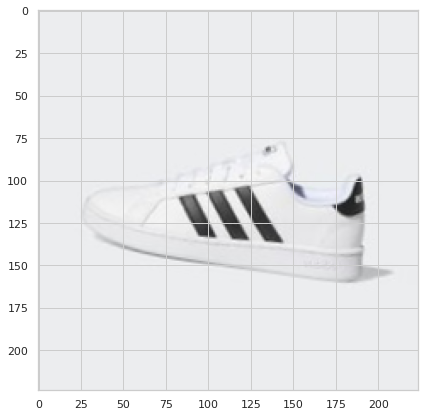

(150, 224, 224, 3)


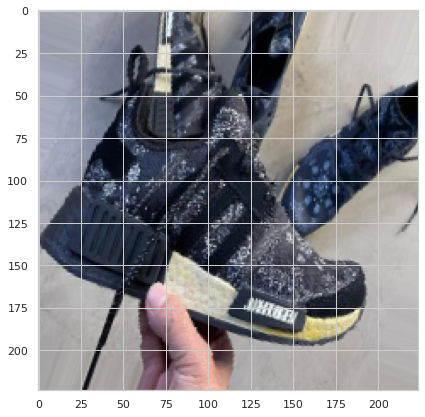

(150, 224, 224, 3)


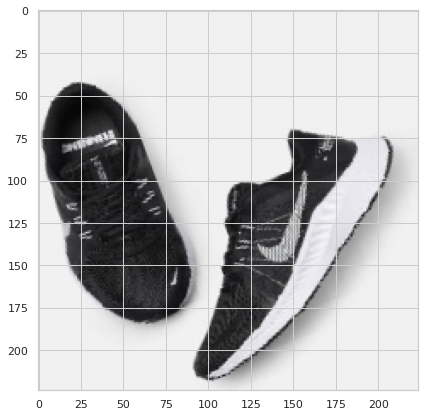

(150, 224, 224, 3)


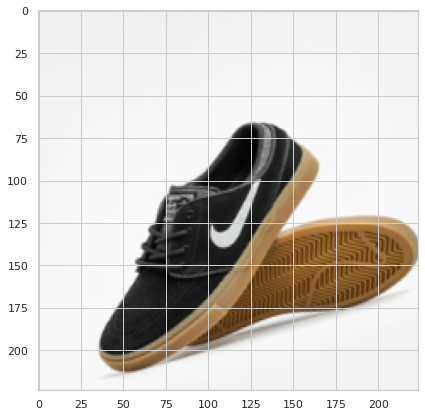

(149, 224, 224, 3)


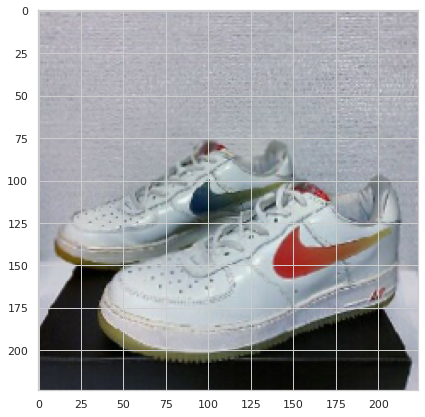

In [13]:
for _ in range(5):
    img, label = train_generator.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

In [14]:
callback = EarlyStopping(
      monitor="val_loss",
      min_delta=0,
      patience=5,
      verbose=0,
      mode="auto",
      baseline=None,
      restore_best_weights=True,
    )

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    verbose=2,
    callbacks=[callback]
)

2022-12-02 14:56:33.470739: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2022-12-02 14:56:39.452887: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


5/5 - 24s - loss: 6.4488 - accuracy: 0.5487 - val_loss: 0.6780 - val_accuracy: 0.6205
Epoch 2/30
5/5 - 14s - loss: 1.6697 - accuracy: 0.5554 - val_loss: 1.7239 - val_accuracy: 0.5670
Epoch 3/30
5/5 - 13s - loss: 1.1963 - accuracy: 0.6395 - val_loss: 0.5817 - val_accuracy: 0.7143
Epoch 4/30
5/5 - 14s - loss: 0.9675 - accuracy: 0.6529 - val_loss: 0.6818 - val_accuracy: 0.6250
Epoch 5/30
5/5 - 14s - loss: 0.8268 - accuracy: 0.7290 - val_loss: 0.4101 - val_accuracy: 0.8214
Epoch 6/30
5/5 - 15s - loss: 0.6793 - accuracy: 0.7690 - val_loss: 0.3222 - val_accuracy: 0.8884
Epoch 7/30
5/5 - 13s - loss: 0.5239 - accuracy: 0.8184 - val_loss: 0.3055 - val_accuracy: 0.8393
Epoch 8/30
5/5 - 13s - loss: 0.4744 - accuracy: 0.8158 - val_loss: 0.2698 - val_accuracy: 0.8973
Epoch 9/30
5/5 - 14s - loss: 0.3988 - accuracy: 0.8344 - val_loss: 0.2881 - val_accuracy: 0.8571
Epoch 10/30
5/5 - 14s - loss: 0.3272 - accuracy: 0.8678 - val_loss: 0.1935 - val_accuracy: 0.9286
Epoch 11/30
5/5 - 14s - loss: 0.3201 - a

Our training finished and the model is looking alright! Let's use it to make predictions.

## Learning Curves 

Let's visualize our model output.

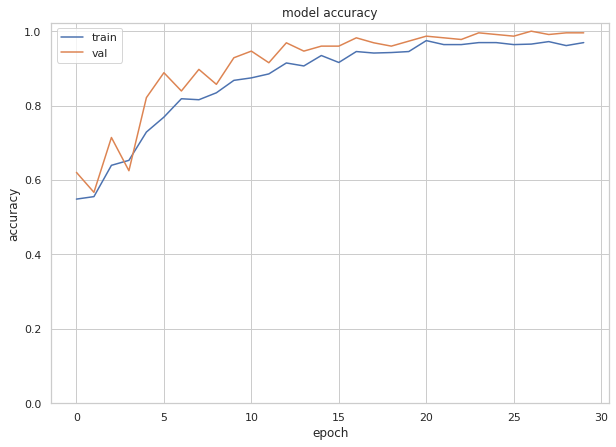

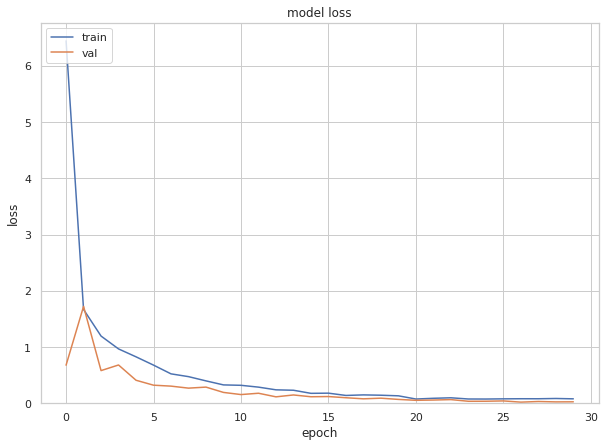

In [15]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim(0)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim(0)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [16]:
test_generator = test_datagen.flow_from_dataframe(testing_df,
                                                  x_col='file_paths',
                                                  y_col='label',
                                                  class_mode='binary',
                                                  batch_size=val_batch_size,
                                                  target_size=(224, 224),
                                                  shuffle=False,
                                                  seed=13)



# Flow validation images in batches of 20 using test_datagen generator
# test_generator = test_datagen.flow_from_directory(
#     path_to_testing_imgs,
#     batch_size=val_batch_size, 
#     class_mode='binary', 
#     target_size=(224, 224),
#     shuffle=False,
#     seed=11
# )

preds = model.predict(test_generator)

Found 321 validated image filenames belonging to 2 classes.


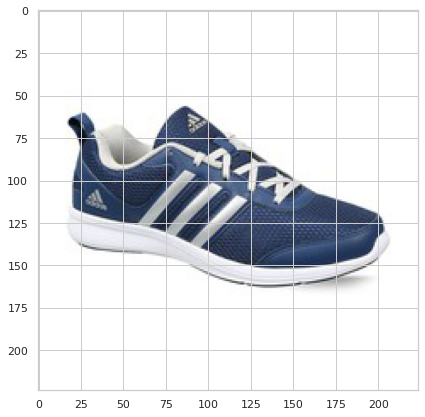

predicted class: Adidas


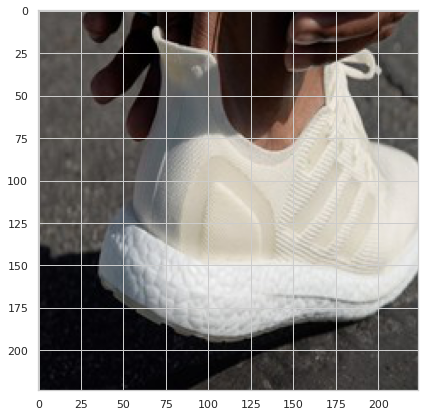

predicted class: Adidas


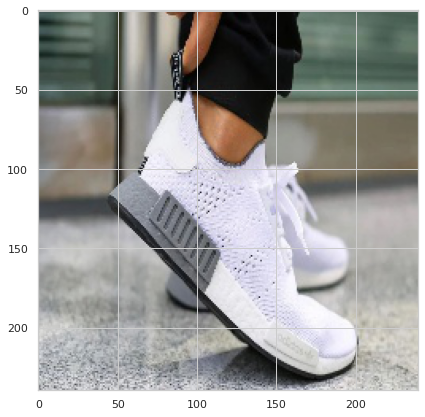

predicted class: Adidas


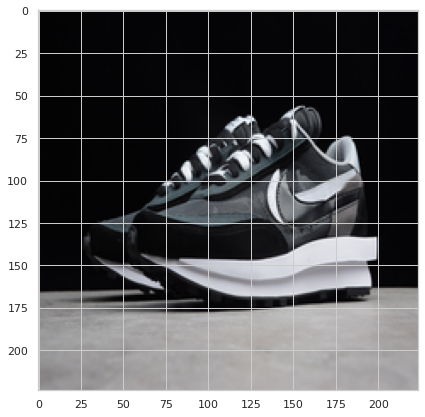

predicted class: Nike


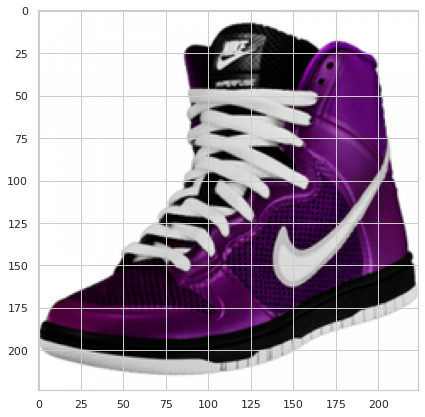

predicted class: Nike


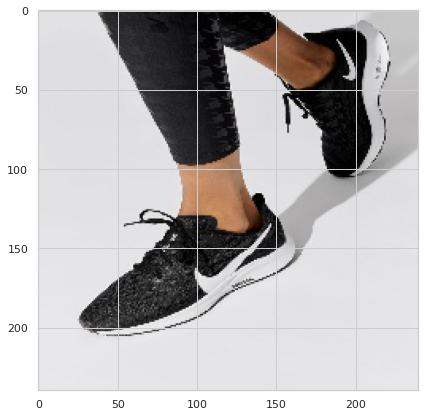

predicted class: Adidas


In [17]:
# Read image
# print(test_generator.filenames)
def getPred(i):
    ex_img = mpimg.imread(test_generator.filepaths[i])
    plt.imshow(ex_img);
    plt.show();
    p = preds[i]
    if p < 0.5:
        output = 'Adidas'
    else:
        output = 'Nike'
    print(f'predicted class: {output}')

,
for i in range(0, 300, 50):
    getPred(i)

## Confusion Matrix & ROC AUC Curves
Accuracy alone does not tell the full story. Let's create a confusion matrix and plot the ROC AUC curve to show how the model performes.

In [18]:
predictions = np.where(preds >= 0.5, 1, 0)
cm = confusion_matrix(predictions, test_generator .classes)
cm

array([[117,  31],
       [ 26, 147]])

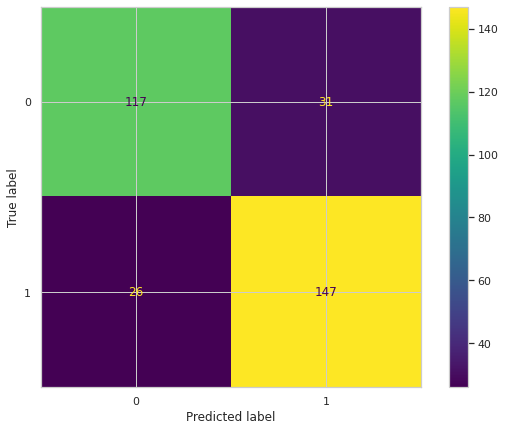

In [19]:
cm_display = ConfusionMatrixDisplay(cm).plot()

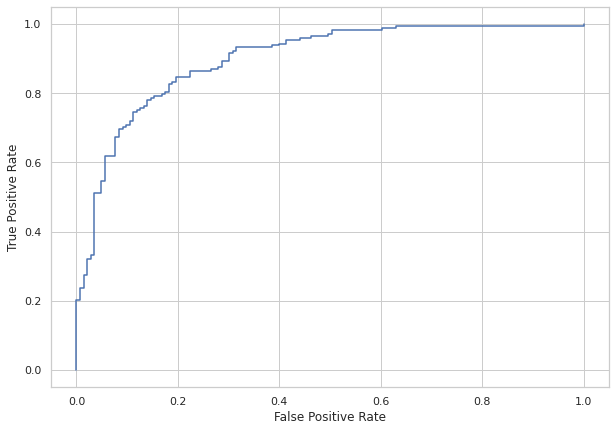

In [20]:
fpr, tpr, _ = roc_curve(
    test_generator.classes, 
    preds   
)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

In [21]:
ras = roc_auc_score(test_generator.classes, preds)
print(f'The model\'s ROC_AUC score is: {ras:.2f}')

The model's ROC_AUC score is: 0.90


## Save the model

Saving the model for future use.

In [22]:
model.save("adidas_nike_classification_model.h5")

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
